<a href="https://colab.research.google.com/github/pedromiola28/NLP-on-tweets--to-forecast-fluctuations-in-the-Nasdaq-index/blob/main/SMSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The hypothesis for this project is that we can find a relation between tweets posted and stock exchange fluctuation one day after the post.

In [546]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from tensorflow import optimizers
import keras
from sklearn.linear_model import LogisticRegression

import numpy as np

from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/My Drive/Dataset/Dataset - Compilado.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [547]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Data pre-processing

In [548]:
import regex as re
import nltk.corpus
import gensim.parsing.preprocessing 
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [549]:
#Stopwords have no useful meaning, so we must remove them
stop = stopwords.words('english') 

#Function to clean the data, removing all symbols and numbers
def limpar(frase): 
  frase = re.sub(r'[^A-Za-z]', ' ', frase)
  frase = frase.lower()
  frase = " ".join([word for word in frase.split() if word not in (stop)])
  return(frase)

In [550]:
#Acessing the data 
df = pd.read_excel(path) 
dados = pd.DataFrame(df)

In [551]:
#Creating a dictionary and a function to change the data format
data_dict = {'abr':'04', 'mai':'05', 'jun':'06', 'jul':'07', 'ago':'08', 'set':'09', 'out':'10'}

def mod_data(data):
  mes = data[-3:]
  data = data.replace(' de ', '/')
  data = data.replace(mes, data_dict[mes])
  if len(data)<5:
    data = '0'+data
  data = pd.to_datetime(data+'/2020', format='%d/%m/%Y')
  return(data)

In [552]:
for i in range (0, len(dados)):
  dados['DATA'][i] = mod_data(dados['DATA'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [553]:
#Joining all the tweets by publishing data. This is possible because for 
# Bag of Words it wont matter the order of the words, just the words themselves.
dados = dados.sort_values('DATA')
frases_comp_data = []
frase = ''
for i in range(0, len(dados)-1):
  a = dados['DATA'][i]
  frase = frase + ' ' + str(dados['Texto'][i])
  if str(a) != str(dados['DATA'][i+1]):
    frases_comp_data.append([a, frase])
    frase = ''

In [554]:
#Cleaning and sorting data
for i in range(0, len(frases_comp_data)):
    frases_comp_data[i][1] = limpar(frases_comp_data[i][1])

frases_comp_data.sort()

# Labelling

In [555]:
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

In [556]:
#Changing the date that the tweet was posted to the date after, to facilitate labelling. Friday, Saturday and Sunday were changed to monday,
# considering that information on this day affects the market on monday.
for i in range(0, len(frases_comp_data)):
  d_semana = frases_comp_data[i][0].weekday()
  if d_semana == 5:
    frases_comp_data[i][0] = frases_comp_data[i][0] + datetime.timedelta(days=2)
  elif d_semana == 4:
    frases_comp_data[i][0] = frases_comp_data[i][0] + datetime.timedelta(days=3)
  else:
    frases_comp_data[i][0] = frases_comp_data[i][0] + datetime.timedelta(days=1)

In [557]:
#Collecting the historical value of Nasdaq, Dow Jones and S&P500, in a 6 month period of time.
nasdaq = yf.Ticker('^IXIC').history(start='2020-04-01',
                                    end='2020-10-01',
                                    interval='1d', 
                                    actions=False,)

dowjones = yf.Ticker('^DJI').history(start='2020-04-01',
                                     end='2020-10-01',
                                     interval='1d', 
                                     actions=False,)

SP500 = yf.Ticker('^GSPC').history(start='2020-04-01',
                                    end='2020-10-01',
                                    interval='1d', 
                                    actions=False,)

In [558]:
#To this classification problem, we are only interested in up's and down's from the market. Thus,
# we must create lists to store this values. 0 is for down (bear market) and 1 is for up (bull market).
nasd_lab, dj_lab, sp_lab = [], [], []

for i in range(0, len(nasdaq)):
    dif1 = nasdaq['Close'] - nasdaq['Open']
    if dif1[i] > 0:
      nasd_lab.append(1)
    else:
      nasd_lab.append(0)

for i in range(0, len(dowjones)):
    dif2 = dowjones['Close'] - dowjones['Open']
    if dif2[i] > 0:
      dj_lab.append(1)
    else:
      dj_lab.append(0)

for i in range(0, len(SP500)):
    dif3 = SP500['Close'] - SP500['Open']
    if dif3[i] > 0:
      sp_lab.append(1)
    else:
      sp_lab.append(0)

In [559]:
df_labels = []
for i in range(0, len(nasdaq)):
  df_labels.append([nasdaq.axes[0][i], nasd_lab[i], dj_lab[i], sp_lab[i]])

In [560]:
#Creating a dataset with all the information that we need: the date, all the tweets posted in one string and the binary labels
dataset = []

for i in range(0, len(frases_comp_data)):
  
  dia = frases_comp_data[i][0]
  palavras = frases_comp_data[i][1]

  for j in range(0, len(df_labels)):
    if dia == df_labels[j][0]:
      label = df_labels[j]
  dataset.append([dia, palavras, label[1], label[2], label[3]])

dataset = pd.DataFrame(dataset)
dataset.columns=['Data','sentences','Nasdaq','Dow Jones','SP500']

#Classification

In [561]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [562]:
#Spliting the dataset columns
sentences = dataset.iloc[:,1:2].squeeze()

labels_nsq = dataset.iloc[:,2:3].squeeze()
labels_dj = dataset.iloc[:,3:4].squeeze()
labels_sp = dataset.iloc[:,4:5].squeeze()

In [563]:
#Using data from Nasdaq and spliting test and training data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels_nsq, test_size = 0.25, random_state = 1000)

In [564]:
#To obtain the best results possible, we should create a for loop to test different frequencies in the word vectorizer.
#Complement Naive Bayes was used because it is suited for a imbalanced dataset, which is the case.
clf_nb = ComplementNB(alpha=0.3)
score = []
pred = []
for i in range(1, 30):
  vect = CountVectorizer(min_df=i)
  x_train = vect.fit_transform(sentences_train)
  x_test = vect.transform(sentences_test)

  feature_names = vect.get_feature_names_out
  clf_nb.fit(x_train, y_train)
  pred_nb = clf_nb.predict(x_test)
  score_nb = metrics.accuracy_score(y_test, pred_nb)
  score.append(score_nb)
  pred.append(pred_nb)

In [565]:
print('Model Accuracy: ' + str(max(score)))

Model Accuracy: 0.6956521739130435


In [566]:
#Assigning the most accurate prediction to pred_nb
pred_nb = pred[score.index(max(score))]

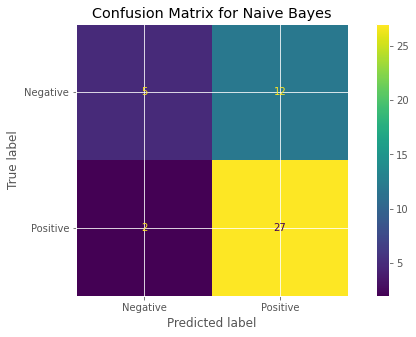

In [567]:
#Confusion matrix
target_names = ['Negative','Positive']
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred_nb, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for Naive Bayes"
)

With the confusion matrix we can see that the prediction is very inaccurate in negative days. To improve this, two approaches were made: assigning weights to the classes and removing data, both to balance the classes.

#Classification - Assigning Weights

In [594]:
from sklearn.utils import class_weight

In [595]:
sentences = dataset.iloc[:,1:2].squeeze()

labels_nsq = dataset.iloc[:,2:3].squeeze()
labels_dj = dataset.iloc[:,3:4].squeeze()
labels_sp = dataset.iloc[:,4:5].squeeze()

In [596]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels_nsq, test_size = 0.25, random_state = 1000)

In [597]:
#Create weights based on the frequency of the labels
sample_weights = class_weight.compute_sample_weight(class_weight = 'balanced', 
                                                  y = y_train)

In [598]:
clf_nb = ComplementNB(alpha=0.3)
score = []
pred = []
for i in range(1, 30):
  vect = CountVectorizer(min_df=i)
  x_train = vect.fit_transform(sentences_train)
  x_test = vect.transform(sentences_test)

  feature_names = vect.get_feature_names_out
  #The weights must be assigned during the fitting process
  clf_nb.fit(x_train, y_train, sample_weight=sample_weights)
  pred_nb = clf_nb.predict(x_test)
  score_nb = metrics.accuracy_score(y_test, pred_nb)
  score.append(score_nb)
  pred.append(pred_nb)

In [599]:
print('Model Accuracy: ' + str(max(score)))

Model Accuracy: 0.6956521739130435


In [600]:
pred_nb = pred[score.index(max(score))]

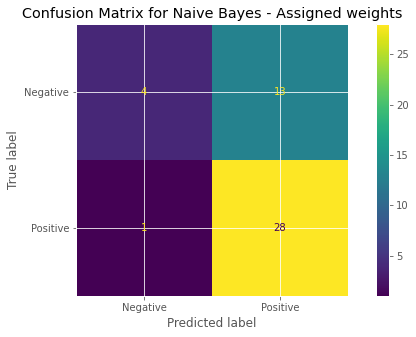

In [601]:
from sklearn.metrics import ConfusionMatrixDisplay
target_names = ['Negative','Positive']
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred_nb, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for Naive Bayes - Assigned weights"
)

#Classification - Removing data

In [585]:
#Spliting the dataset columns
sentences = dataset.iloc[:,1:2].squeeze()

labels_nsq = dataset.iloc[:,2:3].squeeze()
labels_dj = dataset.iloc[:,3:4].squeeze()
labels_sp = dataset.iloc[:,4:5].squeeze()

In [586]:
#Evaluate how many positive days (Nasdaq) there are in the dataset.
j = []
for i in range(0, len(labels_nsq)):
    if labels_nsq[i]==1:
      j.append(1)

j = len(j)
j

122

In [587]:
#Sort dataset by label
dataset_nsq = dataset.sort_values(by='Nasdaq')

In [588]:
#Remove data to balance classes
a = 2*(len(dataset) - j)

sentences = dataset_nsq.iloc[:int(a),1:2].squeeze()

labels_nsq = dataset_nsq.iloc[:int(a),2:3].squeeze()

In [589]:
#Using data from Nasdaq and spliting test and training data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels_nsq, test_size = 0.25, random_state = 800)

In [590]:
score = []
pred = []
for i in range(1, 30):
  vect = CountVectorizer(min_df=i)
  x_train = vect.fit_transform(sentences_train)
  x_test = vect.transform(sentences_test)

  feature_names = vect.get_feature_names_out
  clf_nb.fit(x_train, y_train)
  pred_nb = clf_nb.predict(x_test)
  score_nb = metrics.accuracy_score(y_test, pred_nb)
  score.append(score_nb)
  pred.append(pred_nb)

In [591]:
print('Model Accuracy: ' + str(max(score)))

Model Accuracy: 0.7666666666666667


In [592]:
#Assigning the most accurate prediction to pred_nb
pred_nb = pred[score.index(max(score))]

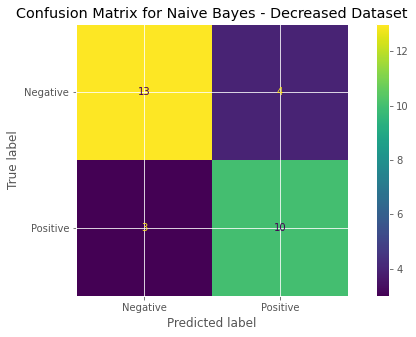

In [593]:
from sklearn.metrics import ConfusionMatrixDisplay
target_names = ['Negative','Positive']
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred_nb, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for Naive Bayes - Decreased Dataset"
)